In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('monthly_milk_production.csv', index_col='Date',parse_dates=True)
df.index.freq='MS'

In [ ]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: xlabel='Date'>

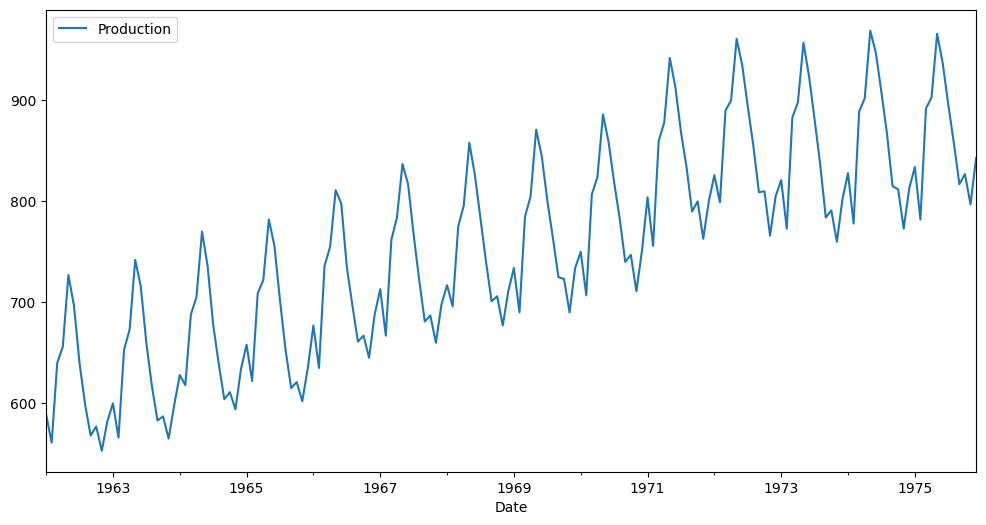

In [ ]:
df.plot(figsize=(12,6))

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

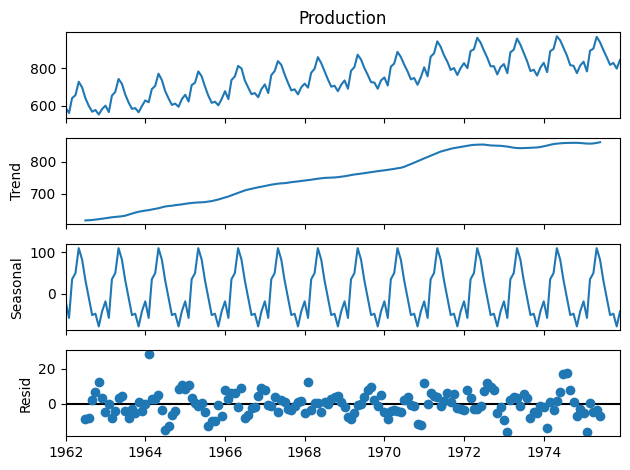

In [ ]:
results = seasonal_decompose(df['Production'])
results.plot();

In [ ]:
len(df)

168

In [ ]:
train = df.iloc[:156]
test = df.iloc[156:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [ ]:
X.shape

(1, 3, 1)

In [ ]:
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
from keras.models import Sequential
from keras. layers import Dense
from keras.layers import LSTM

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(generator, epochs=50)

Epoch 1/50
132/132 [==============================] - 4s 15ms/step - loss: 0.0387
Epoch 2/50
132/132 [==============================] - 2s 15ms/step - loss: 0.0265
Epoch 3/50
132/132 [==============================] - 3s 25ms/step - loss: 0.0250
Epoch 4/50
132/132 [==============================] - 2s 15ms/step - loss: 0.0229
Epoch 5/50
132/132 [==============================] - 2s 14ms/step - loss: 0.0237
Epoch 6/50
132/132 [==============================] - 2s 15ms/step - loss: 0.0217
Epoch 7/50
132/132 [==============================] - 3s 23ms/step - loss: 0.0200
Epoch 8/50
132/132 [==============================] - 2s 15ms/step - loss: 0.0204
Epoch 9/50
132/132 [==============================] - 2s 14ms/step - loss: 0.0139
Epoch 10/50
132/132 [==============================] - 2s 15ms/step - loss: 0.0110
Epoch 11/50
132/132 [==============================] - 2s 14ms/step - loss: 0.0108
Epoch 12/50
132/132 [==============================] - 3s 26ms/step - loss: 0.0086
Epoch 13/50
1

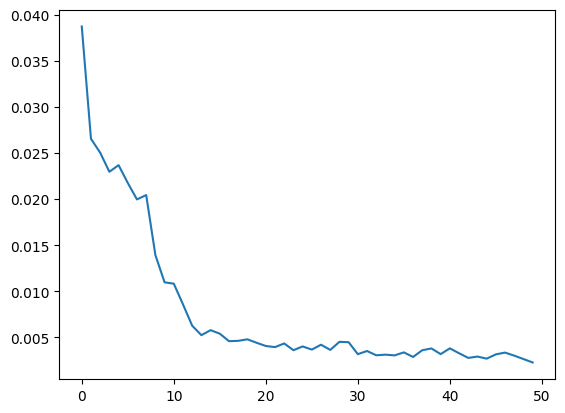

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
last_train_batch = scaled_train[-12:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(last_train_batch)


1/1 [==============================] - 0s 171ms/step


array([[0.6101618]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.67548077])

In [ ]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
num_predictions = 24  # Adjust the number of months you want to predict

for i in range(num_predictions):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)


1/1 [==============================] - 0s 45ms/step


In [ ]:
print(len(test_predictions))

24


In [ ]:
test.tail()

,Production,Predictions
Date,,
1975-08-01,858,835.665298
1975-09-01,817,796.965523
1975-10-01,827,780.801613
1975-11-01,797,767.650707
1975-12-01,843,784.734879


In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)
print(true_predictions)
# test['Predictions'] = true_predictions

[[806.82730103]
 [804.37626266]
 [865.24443436]
 [894.42225456]
 [925.05247307]
 [913.08605003]
 [879.30379868]
 [835.66529846]
 [796.96552277]
 [780.80161285]
 [767.65070724]
 [784.73487854]
 [806.33520889]
 [806.22826576]
 [872.52695656]
 [902.68881226]
 [936.13116646]
 [927.37809563]
 [896.25427246]
 [854.01746368]
 [813.69955635]
 [792.95876312]
 [775.2293129 ]
 [788.55906868]]


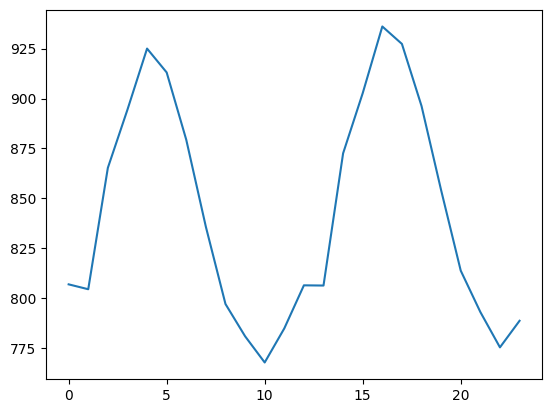

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(true_predictions)


<Axes: xlabel='Date'>

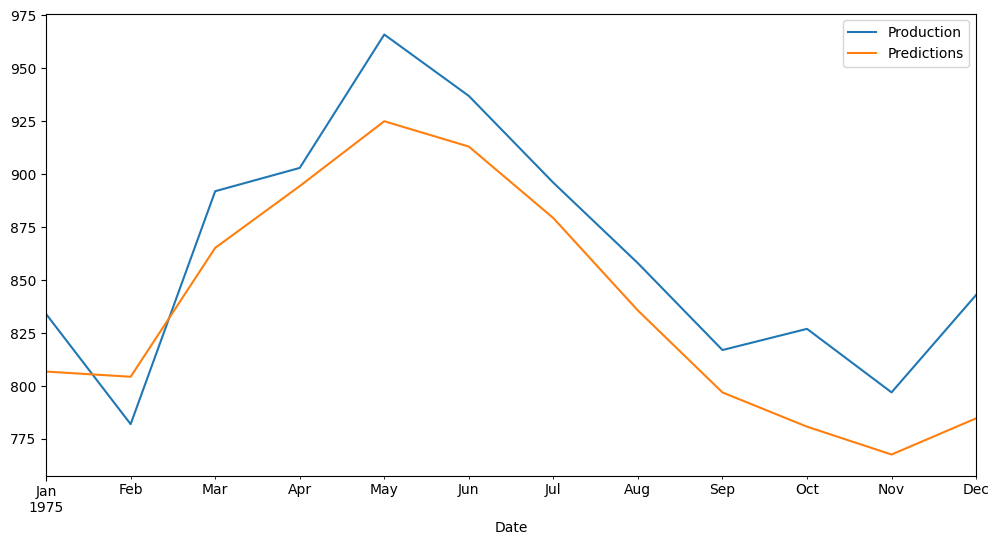

In [ ]:
test.plot(figsize=(12,6))

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'], test['Predictions']))
print(rmse)

31.419933061776394
